In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set the dataset path
dataset_path = '/kaggle/input/50-car-brands-photos/car brand dataset'

# List all car brands (folders)
brands = os.listdir(dataset_path)
print(f"Total car brands found: {len(brands)}")

# Count images in each brand
brand_counts = {}
for brand in brands:
    brand_path = os.path.join(dataset_path, brand)
    if os.path.isdir(brand_path):
        # Filter out non-file entries like .DS_Store if any
        image_files = [f for f in os.listdir(brand_path) if os.path.isfile(os.path.join(brand_path, f))]
        image_count = len(image_files)
        brand_counts[brand] = image_count

# Print counts in a formatted table ---
print("\n--- Image Counts per Brand ---")

if brand_counts:
    # Sort the dictionary by brand name (key)
    sorted_brands = sorted(brand_counts.items())
    
    # Find max length for padding (for alignment)
    max_brand_len = max(len(brand) for brand in brand_counts.keys())
    # Find max number of digits for the counter (e.g., 50 brands -> 2 digits)
    max_num_len = len(str(len(sorted_brands)))

    # Print in the requested format
    for i, (brand, count) in enumerate(sorted_brands, 1):
        # {i:>{max_num_len}} -> right-aligns the number (e.g., " 1", "10")
        # {brand:<{max_brand_len}} -> left-aligns the brand name
        print(f"  {i:>{max_num_len}}. {brand:<{max_brand_len}} - {count} images")
else:
    print("  No car brands found or directory is empty.")


# Display statistics (also protected by a check)
if brand_counts:
    print(f"\nTotal images across all brands: {sum(brand_counts.values())}")
    print(f"Average images per brand: {np.mean(list(brand_counts.values())):.1f}")
    print(f"Min images in a brand: {min(brand_counts.values())}")
    print(f"Max images in a brand: {max(brand_counts.values())}")
else:
    print("\nNo statistics to display.")

Total car brands found: 50

--- Image Counts per Brand ---
   1. Acura         - 90 images
   2. Alfa Romeo    - 89 images
   3. Aston Martin  - 91 images
   4. Audi          - 1099 images
   5. BMW           - 84 images
   6. Bentley       - 91 images
   7. Bugatti       - 92 images
   8. Buick         - 93 images
   9. Cadillac      - 86 images
  10. Chevrolet     - 88 images
  11. Chrysler      - 89 images
  12. Citroen       - 91 images
  13. Daewoo        - 105 images
  14. Dodge         - 85 images
  15. Ferrari       - 98 images
  16. Fiat          - 89 images
  17. Ford          - 89 images
  18. GMC           - 94 images
  19. Genesis       - 99 images
  20. Honda         - 90 images
  21. Hudson        - 102 images
  22. Hyundai       - 428 images
  23. Infiniti      - 91 images
  24. Jaguar        - 95 images
  25. Jeep          - 88 images
  26. Kia           - 85 images
  27. Land Rover    - 87 images
  28. Lexus         - 84 images
  29. Lincoln       - 102 images
  30. M

In [7]:
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Create lists to store results
corrupted_images = []
valid_images = []
image_dimensions = []

# Check each image
print("Scanning images for corruption and validity...")
total_checked = 0

for brand in brands:
    brand_path = os.path.join(dataset_path, brand)
    if os.path.isdir(brand_path):
        images = os.listdir(brand_path)
        for img_file in images:
            img_path = os.path.join(brand_path, img_file)
            total_checked += 1
            
            try:
                # Try to open and verify the image
                img = Image.open(img_path)
                img.verify()  # Verify image integrity
                
                # Reopen to get dimensions (verify closes the file)
                img = Image.open(img_path)
                width, height = img.size
                image_dimensions.append((width, height))
                valid_images.append(img_path)
                
            except Exception as e:
                # If any error, it's corrupted
                corrupted_images.append({
                    'file': img_path,
                    'error': str(e)
                })

print(f"\nTotal images scanned: {total_checked}")
print(f"Valid images: {len(valid_images)}")
print(f"Corrupted images: {len(corrupted_images)}")

if corrupted_images:
    print(f"\nCorrupted images list:")
    for item in corrupted_images[:5]:  # Show first 5
        print(f"  - {item['file']}: {item['error']}")

# Image dimension statistics
if image_dimensions:
    dims_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])
    print(f"\nImage dimension statistics:")
    print(dims_df.describe())

Scanning images for corruption and validity...

Total images scanned: 7439
Valid images: 7439
Corrupted images: 0

Image dimension statistics:
             Width       Height
count  7439.000000  7439.000000
mean    281.089259   177.891652
std      42.095956    24.867416
min     100.000000    92.000000
25%     259.000000   168.000000
50%     280.000000   177.000000
75%     300.000000   192.000000
max     546.000000   399.000000


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import os
from PIL import Image
import numpy as np

# Set dataset path
dataset_path = '/kaggle/input/50-car-brands-photos/car brand dataset'

# Load pre-trained MobileNetV2 model
print("Loading MobileNetV2 model...")
model = MobileNetV2(weights='imagenet')
print("✓ Model loaded successfully")

# Car-related classes in ImageNet
car_keywords = ['car', 'automobile', 'vehicle', 'sedan', 'coupe', 'SUV', 'truck', 
                'sports car', 'convertible', 'station wagon', 'minivan']

non_car_images = []
car_images = []

# Get all brands and recreate valid_images list
brands = os.listdir(dataset_path)
valid_images = []
for brand in brands:
    brand_path = os.path.join(dataset_path, brand)
    if os.path.isdir(brand_path):
        images = os.listdir(brand_path)
        for img_file in images:
            img_path = os.path.join(brand_path, img_file)
            valid_images.append(img_path)

print("\nScanning all images for car detection...")
total_images = len(valid_images)
processed = 0

for img_path in valid_images:
    processed += 1
    if processed % 500 == 0:
        print(f"  Processed: {processed}/{total_images}")
    
    try:
        # Load and prepare image
        img = Image.open(img_path).resize((224, 224))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Predict
        predictions = model.predict(img_array, verbose=0)
        decoded = decode_predictions(predictions, top=1)[0]
        
        # Check if top prediction is car-related
        predicted_class = decoded[0][1].lower()
        is_car = any(keyword in predicted_class for keyword in car_keywords)
        
        if is_car:
            car_images.append(img_path)
        else:
            non_car_images.append({
                'path': img_path,
                'predicted': predicted_class,
                'confidence': float(decoded[0][2])
            })
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print(f"\n✓ Scan complete!")
print(f"Total images checked: {total_images}")
print(f"Car images detected: {len(car_images)}")
print(f"Non-car images detected: {len(non_car_images)}")

if non_car_images:
    print(f"\nSample of non-car images detected:")
    for item in non_car_images[:10]:
        print(f"  - Predicted: {item['predicted']} (confidence: {item['confidence']:.2f})")

Loading MobileNetV2 model...
✓ Model loaded successfully

Scanning all images for car detection...
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  Processed: 500/7439
  Processed: 1000/7439
  Processed: 1500/7439
  Processed: 2000/7439
  Processed: 2500/7439
  Processed: 3000/7439
  Processed: 3500/7439
  Processed: 4000/7439
  Processed: 4500/7439
  Processed: 5000/7439
  Processed: 5500/7439
  Processed: 6000/7439
  Processed: 6500/7439
  Processed: 7000/7439

✓ Scan complete!
Total images checked: 7439
Car images detected: 5013
Non-car images detected: 2426

Sample of non-car images detected:
  - Predicted: minibus (confidence: 0.80)
  - Predicted: beach_wagon (confidence: 0.28)
  - Predicted: cab (confidence: 0.22)
  - Predicted: beach_wagon (confidence: 0.31)
  - Predicted: beach_wagon (confidence: 0.28)
  - Predicted: jeep (confidence: 0.57)
  - Predicted: limousine (confidence: 0.29)
  - Predicted: beach_wagon (confidence: 0.27)
  - Predicted: racer (confidence: 0.37)
  - Predict

**REMOVE NON CAR IMAGES**

In [7]:
import shutil
from pathlib import Path

# Create a new clean dataset directory
clean_dataset_path = '/kaggle/working/clean_car_dataset'
os.makedirs(clean_dataset_path, exist_ok=True)

print("Creating clean dataset structure...")
print(f"Source: {dataset_path}")
print(f"Destination: {clean_dataset_path}")

# Copy only car images to new directory, maintaining brand structure
removed_count = 0
copied_count = 0

for brand in brands:
    brand_clean_path = os.path.join(clean_dataset_path, brand)
    os.makedirs(brand_clean_path, exist_ok=True)

# Copy car images
for img_path in car_images:
    try:
        # Extract brand name from path
        brand = img_path.split(os.sep)[-2]
        img_name = os.path.basename(img_path)
        dest_path = os.path.join(clean_dataset_path, brand, img_name)
        
        shutil.copy2(img_path, dest_path)
        copied_count += 1
        
        if copied_count % 1000 == 0:
            print(f"  Copied: {copied_count}/{len(car_images)}")
    
    except Exception as e:
        print(f"Error copying {img_path}: {e}")

removed_count = len(non_car_images)

print(f"\n✓ Clean dataset created!")
print(f"Images copied: {copied_count}")
print(f"Images removed: {removed_count}")
print(f"Removal rate: {(removed_count/total_images)*100:.2f}%")

# Verify the clean dataset
clean_brands = os.listdir(clean_dataset_path)
clean_brand_counts = {}
total_clean_images = 0

for brand in clean_brands:
    brand_path = os.path.join(clean_dataset_path, brand)
    if os.path.isdir(brand_path):
        count = len(os.listdir(brand_path))
        clean_brand_counts[brand] = count
        total_clean_images += count

print(f"\nClean dataset statistics:")
print(f"Total brands: {len(clean_brand_counts)}")
print(f"Total images: {total_clean_images}")
print(f"Average images per brand: {np.mean(list(clean_brand_counts.values())):.1f}")
print(f"Min images: {min(clean_brand_counts.values())}")
print(f"Max images: {max(clean_brand_counts.values())}")

Creating clean dataset structure...
Source: /kaggle/input/50-car-brands-photos/car brand dataset
Destination: /kaggle/working/clean_car_dataset
  Copied: 1000/5013
  Copied: 2000/5013
  Copied: 3000/5013
  Copied: 4000/5013
  Copied: 5000/5013

✓ Clean dataset created!
Images copied: 5013
Images removed: 2426
Removal rate: 32.61%

Clean dataset statistics:
Total brands: 50
Total images: 5013
Average images per brand: 100.3
Min images: 6
Max images: 821


Unique non-car predictions found: 229

Top 10 non-car categories:
  beach_wagon: 686 images
  pickup: 255 images
  limousine: 189 images
  jeep: 173 images
  racer: 133 images
  grille: 131 images
  minibus: 106 images
  cab: 57 images
  moving_van: 54 images
  cassette_player: 33 images


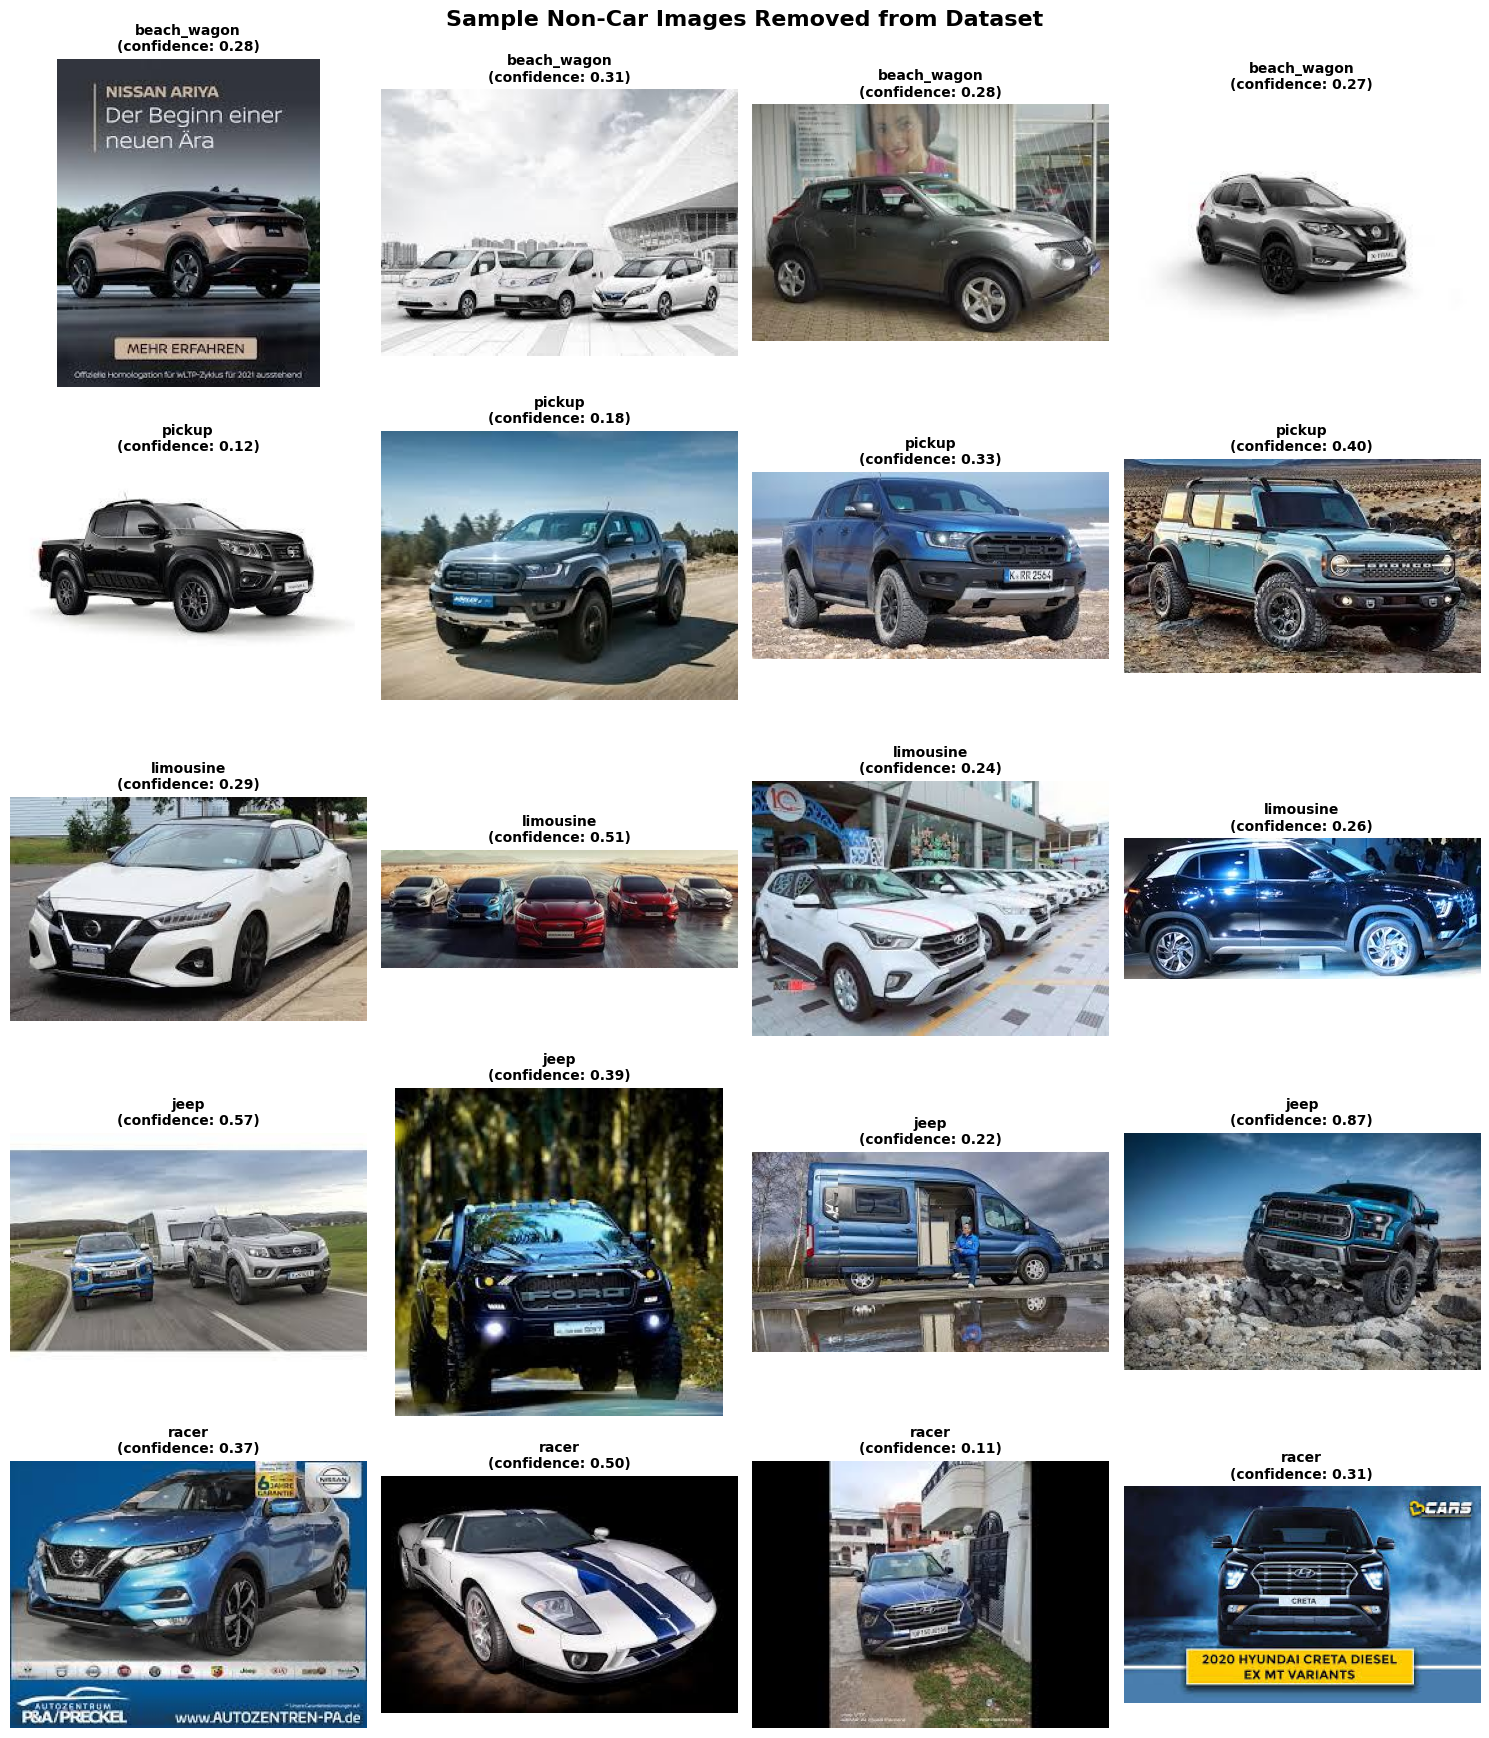


✓ Non-car samples visualized


In [8]:
import matplotlib.pyplot as plt
from PIL import Image

# Get unique non-car predictions
non_car_predictions = {}
for item in non_car_images:
    pred = item['predicted']
    if pred not in non_car_predictions:
        non_car_predictions[pred] = []
    non_car_predictions[pred].append(item)

print(f"Unique non-car predictions found: {len(non_car_predictions)}")
print("\nTop 10 non-car categories:")
sorted_preds = sorted(non_car_predictions.items(), key=lambda x: len(x[1]), reverse=True)
for pred, items in sorted_preds[:10]:
    print(f"  {pred}: {len(items)} images")

# Visualize sample non-car images from top categories
fig, axes = plt.subplots(5, 4, figsize=(15, 18))
fig.suptitle('Sample Non-Car Images Removed from Dataset', fontsize=16, fontweight='bold')

plot_idx = 0
for pred, items in sorted_preds[:5]:  # Top 5 categories
    for j in range(4):  # 4 samples per category
        if plot_idx < 20:
            row = plot_idx // 4
            col = plot_idx % 4
            
            try:
                img_path = items[j]['path']
                img = Image.open(img_path)
                
                axes[row, col].imshow(img)
                axes[row, col].set_title(f'{pred}\n(confidence: {items[j]["confidence"]:.2f})', 
                                         fontsize=10, fontweight='bold')
                axes[row, col].axis('off')
                plot_idx += 1
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.savefig('non_car_samples.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Non-car samples visualized")